# Event Study

_All strange and terrible events are welcome, but comforts we despise_ - Cleopatra

Concepts
- Abnormal returns
- Convolution Theorem
- Multiple testing

References:
-  Kolari, James W. and Pynnonen, Seppo, 2010, "Event Study Testing with Cross-sectional Correlation of Abnormal Returns". The Review of Financial Studies, 23(11), 3996-4025

- Kolari, James W., Paper, Bernd, and Pynnonen, Seppo, 2018, "Event Study Testing with Cross-sectional Correlation Due to Partially Overlapping Event Windows", working paper

MIT License.  Copyright 2021-2024 Terence Lim

In [1]:

import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
from scipy.stats import norm
from statsmodels.stats.multitest import multipletests
from tqdm import tqdm
import warnings
from finds.database import SQL, RedisDB
from finds.structured import BusDay, Benchmarks, Stocks, CRSP, PSTAT
from finds.backtesting import EventStudy
from secret import credentials, paths, CRSP_DATE
VERBOSE = 0
if not VERBOSE:
    warnings.simplefilter(action='ignore', category=FutureWarning)
#%matplotlib qt

In [2]:
# open connections
sql = SQL(**credentials['sql'], verbose=VERBOSE)
user = SQL(**credentials['user'], verbose=VERBOSE)
bd = BusDay(sql)
rdb = RedisDB(**credentials['redis'])
keydev = PSTAT(sql, bd, verbose=VERBOSE)
crsp = CRSP(sql, bd, rdb=rdb, verbose=VERBOSE)
bench = Benchmarks(sql, bd, verbose=VERBOSE)
eventstudy = EventStudy(user, bench=bench, stocks=crsp, max_date=CRSP_DATE)
imgdir = paths['images'] / 'events'

Last FamaFrench Date 2024-02-29 00:00:00


## Abnormal returns

Event studies assess the impact on stock returns of a company-specific
event such as a merger or company announcement. They investigate deviations of stock returns from expected returns, called abnormal returns, on days around the disclosure of
news.

Define the date of the announcement or event $t=0$, and
the daily stock return for each firm $i$ is $R_{i,t}$.  Returns of a market- or
sector-reference group $R_{m,t}$ is computed as comparison. Then:

- Abnormal returns (AR) for each stock $i$ at time $t$ are defined as
  $$AR_{i,t} = R_{i,t} - R_{m,t}$$

- Average abnormal returns (AAR) across firms are defined as
  $$AAR_t = \dfrac{1}{N}\sum_i^N AR_{i,t}$$

- Cumulative average abnormal returns (CAR) are defined over time as
  $$CAR_T = \sum_t AAR_t$$

- Buy-and-hold average abnormal returns (BHAR) are defined across firms'
  buy-and-hold returns as
  $$BHAR_T = \dfrac{1}{N} \sum_i^N [\Pi_t (1+ AR_{i,t}) - \Pi_t (1+ R_{m,t}) ]$$



### Announcement effect

An announcement effect is the immediate spike in stock price upon
the announcemnt or event. An efficient reaction is one where the
stock price maintains its new level after the event.  An
under-reaction occurs when the stock prices continues to trend in the
same direction after the announcement.  An over-reaction occurs when
stock prices drift in the oppositve direction after the initial
spike.

Often, the exact date and time canot be pinpointed in historical data. An announcement window around the recorded announcement date, often encompassing one day before and after, accounts for this uncertainty.

A __pre-announcement drift__ of stock prices could be consistent with insider information being leaked prior to the announcement, or other explanations.
A __post-announcement drift__ may possibly due to under- or over-reaction of investors to the news released.

When measuring announcement effects from many stocks and dates, the returns of stocks with the same announcement date are typically averaged together, so the dataset is reduced to unique announcement dates. Even after this transformation, Kolari et al (2010) demonstrate that even small cross-sectional correlation of abnormal returns can cause severe over-rejection of the null hypothesis of zero abnormal returns. In the presense of such cross-sectional correlations, an unbiased estimate of the mean abnormal return $\sigma^2$ is given by:

$$\sigma^{2} = \dfrac{s^2}{n}(1 + (n - 1) \hat{r})$$
 
where $\hat{r}$ is the average of the sample cross-sectional
correlations of the estimation-period residuals, and $s^2$ is the
(biased) cross-sectional standard deviation of the abnormal returns.




Retrieve event dates and company roles from CapitalIQ Key Developments

In [3]:
# sorted list of all eventids and roleids, provided in keydev class
events = sorted(keydev.event.index)
roles = sorted(keydev.role.index)

In [4]:
# str formatter to pretty print descriptions, provided in keydev class
eventformat = lambda e, r: "{event} ({eventid}) {role} [{roleid}]"\
    .format(event=keydev.event[e], eventid=e, role=keydev.role[r], roleid=r) 

In [5]:
# event window parameters
left, right, post = -1, 1, 21
end = bd.offset(CRSP_DATE, post - left)
beg = 20020101
mindays = 1000

Helper functions to retrieve size decile of universe stocks and run event study pipeline

In [6]:

class Universe:
    """Helper to lookup prevailing size decile of universe stocks"""
    def __init__(self, beg: int, end: int, stocks: Stocks, annual: bool = False):
        # whether to offset previous month or year end when lookup
        self.offset = stocks.bd.endyr if annual else stocks.bd.endmo
        
        # populate dictionary, keyed by permno and date, with size decile
        self.decile = dict()
        date_range = stocks.bd.date_range(start=self.offset(beg, -1), end=end,
                                          freq=12 if annual else 'e')
        for date in date_range:
            univ = crsp.get_universe(date)
            for permno in univ.index:
                self.decile[(permno, date)] = univ.loc[permno, 'decile']

    def __getitem__(self, item):
        """Returns size decile, else 0 if not universe stock"""
        permno, date = item
        return self.decile.get((permno, self.offset(date, -1)), 0)
    
univ = Universe(beg=beg, end=end, stocks=crsp)

# run event study after screening stock universe
def event_pipeline(eventstudy: EventStudy,
                   beg: int,
                   end: int,
                   eventid: int,
                   roleid: int,
                   left: int,
                   right: int,
                   post: int) -> DataFrame:
    """helper to screen stock universe, and merge keydev events and crsp daily"""

    # Retrieve announcement dates for this event
    df = keydev.get_linked(
        dataset='keydev',
        date_field='announcedate',
        fields=['keydevid',
                'keydeveventtypeid',
                'keydevtoobjectroletypeid'],
        where=(f"announcedate >= {beg} "
               f"  and announcedate <= {end}"
               f"  and keydeveventtypeid = {eventid} "
               f"  and keydevtoobjectroletypeid = {roleid}"))\
               .drop_duplicates(['permno', 'announcedate'])\
               .set_index(['permno', 'announcedate'], drop=False)

    # Require universe size decile
    df['size'] = [univ[row.permno, row.announcedate] for row in df.itertuples()]

    # Call eventstudy to retrieve daily abnormal returns, with named label
    rows = eventstudy(label=f"{eventid}_{roleid}",
                      df=df[df['size'].gt(0)],
                      left=left,
                      right=right,
                      post=post,
                      date_field='announcedate')
    return df.loc[rows.to_records(index=False).tolist()] # restrict successful rows

Show subsample plots for events with large post-announcement drift


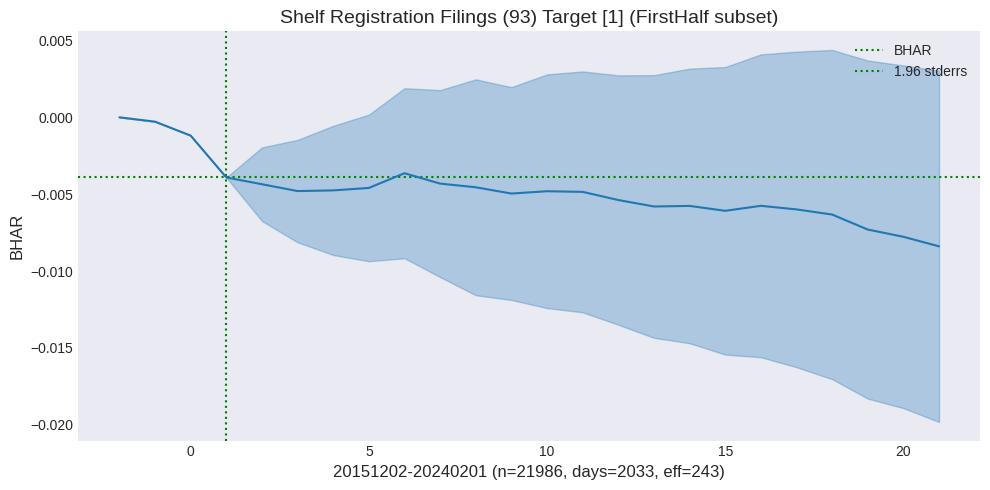

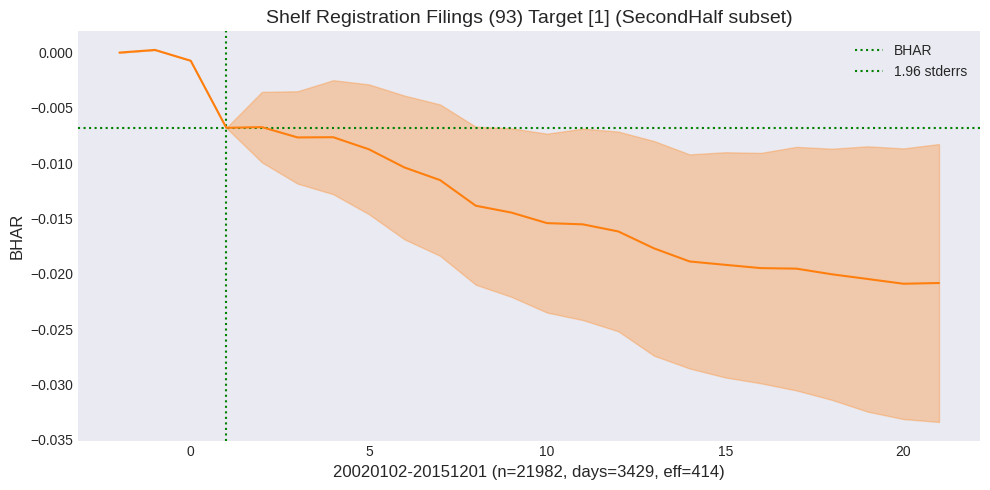

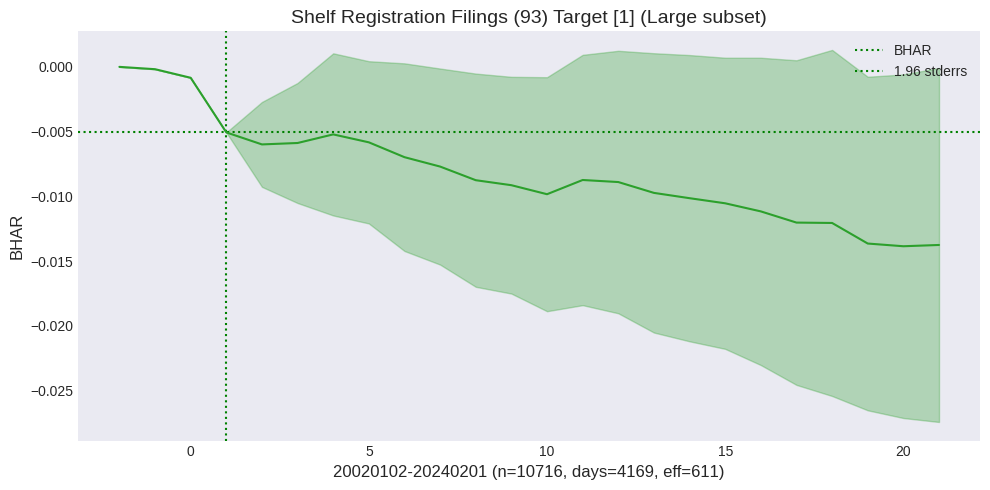

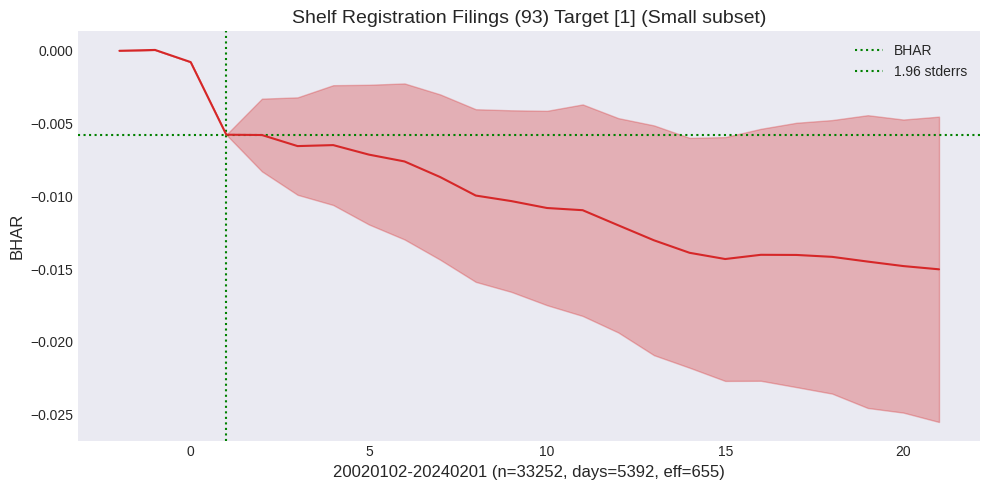

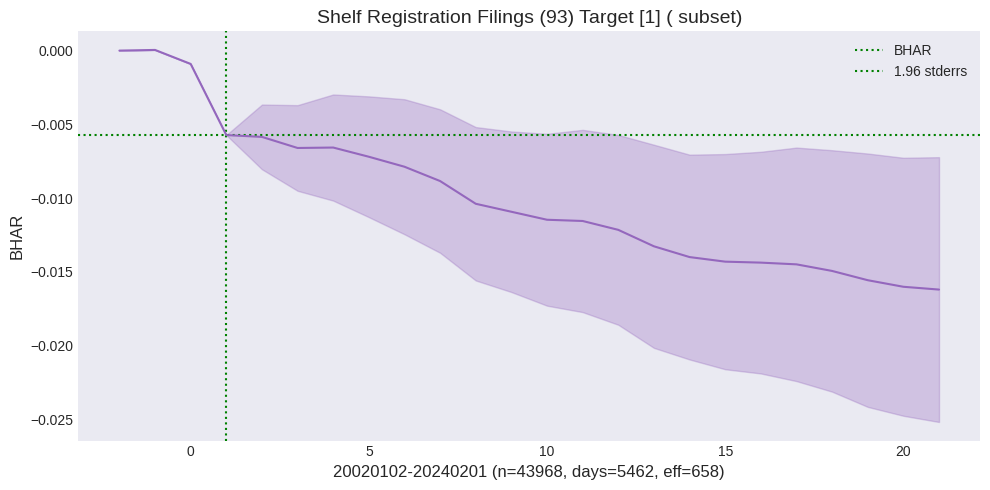

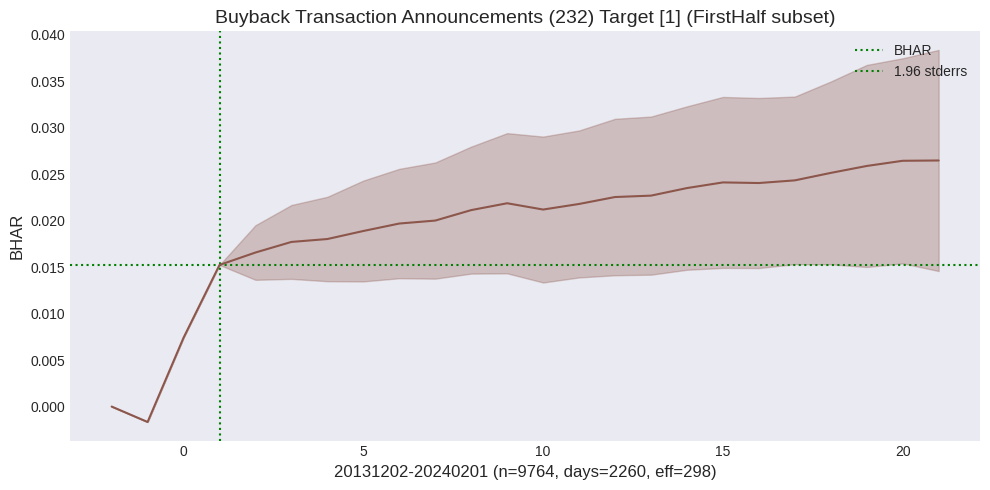

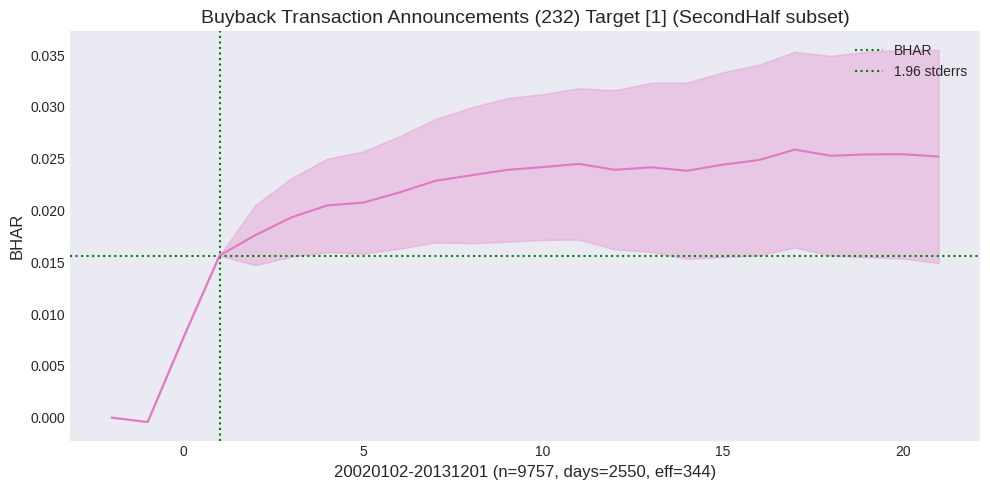

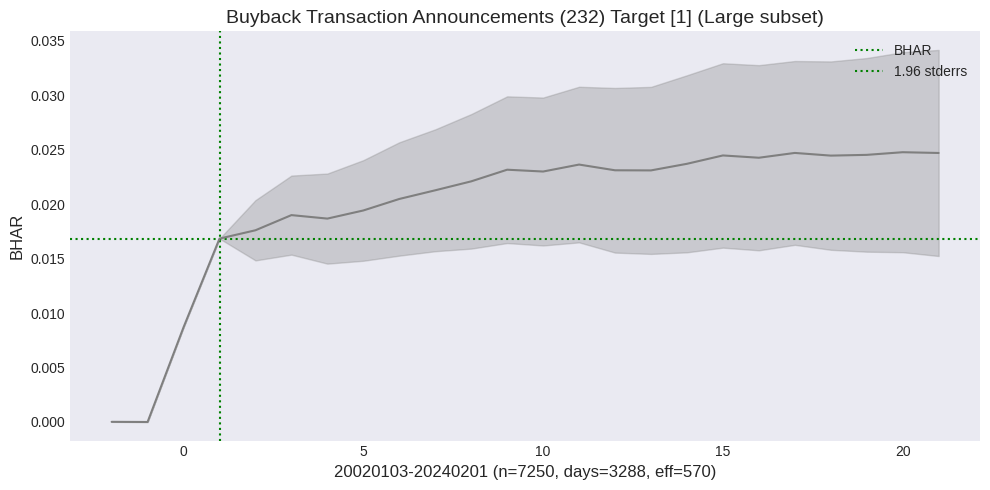

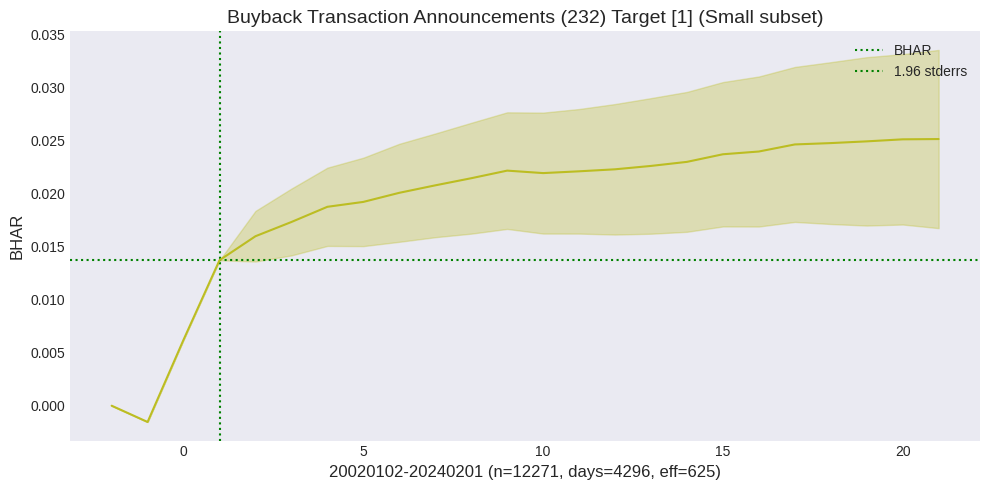

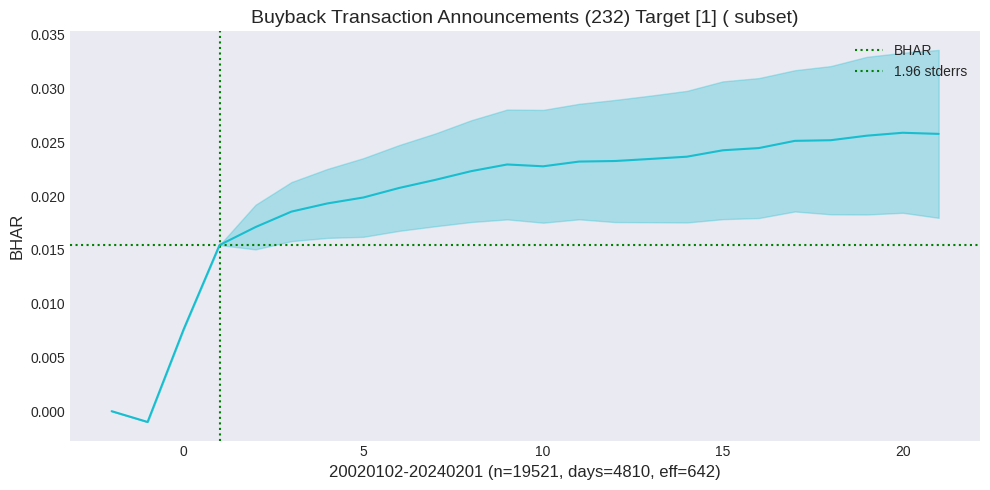

In [38]:
events_list = [[93, 1], [232, 1]]  # largest drift returns
for i, (eventid, roleid) in enumerate(events_list):
    df = event_pipeline(eventstudy,eventid=eventid,
                        roleid=roleid,
                        beg=beg,
                        end=end,
                        left=left,
                        right=right,
                        post=post)
    halfperiod = np.median(df['announcedate'])
    sample = {'FirstHalf': df['announcedate'].ge(halfperiod).values,
              'SecondHalf': df['announcedate'].lt(halfperiod).values,
              'Large': df['size'].le(5).values,
              'Small': df['size'].gt(5).values,
              '': []}
    for ifig, (label, rows) in enumerate(sample.items()):
        fig, ax = plt.subplots(clear=True, figsize=(10, 5))
        bhar = eventstudy.fit(model='sbhar', rows=rows)
        eventstudy.plot(model='sbhar',
                        title=eventformat(eventid, roleid) + f" ({label} subset)",
                        drift=True,
                        ax=ax,
                        c=f"C{i*5+ifig}")
        plt.tight_layout()
        plt.savefig(imgdir / (label + f"{eventid}_{roleid}.jpg"))

Show subsample plots for events with large announcement window returns

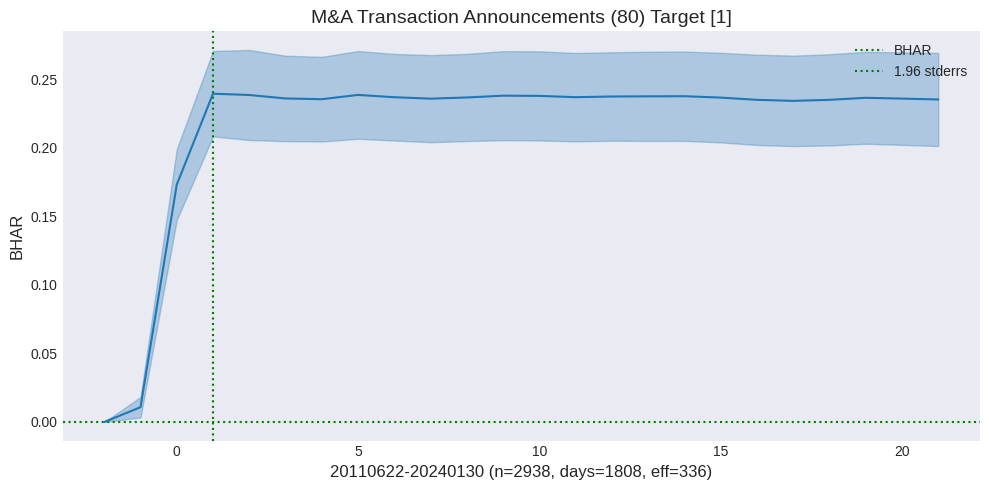

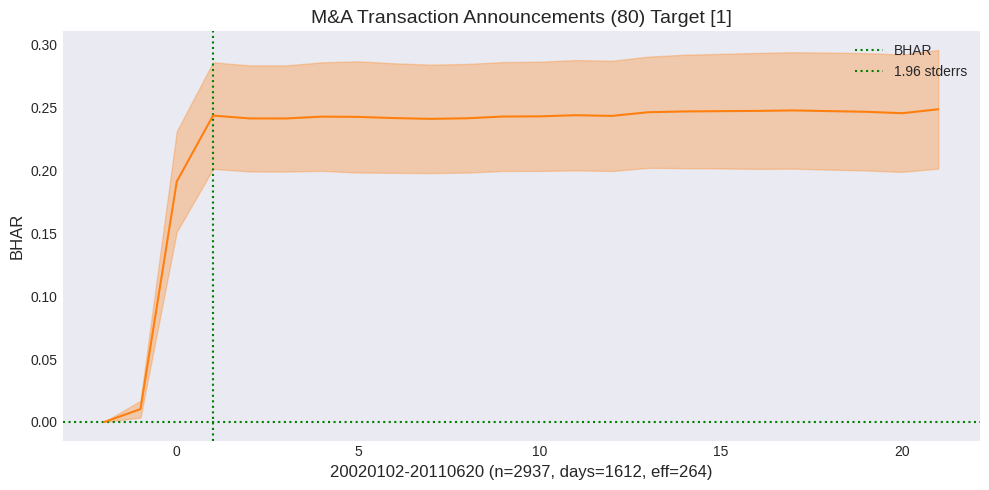

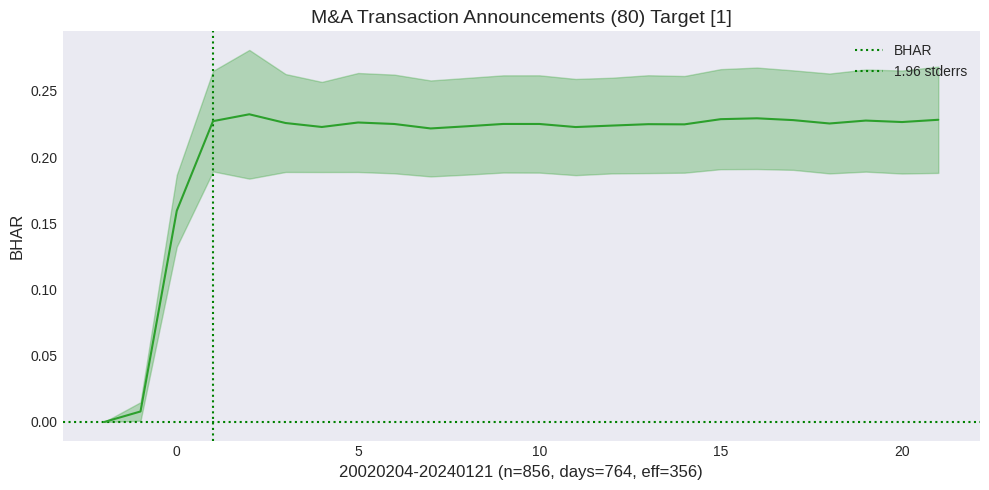

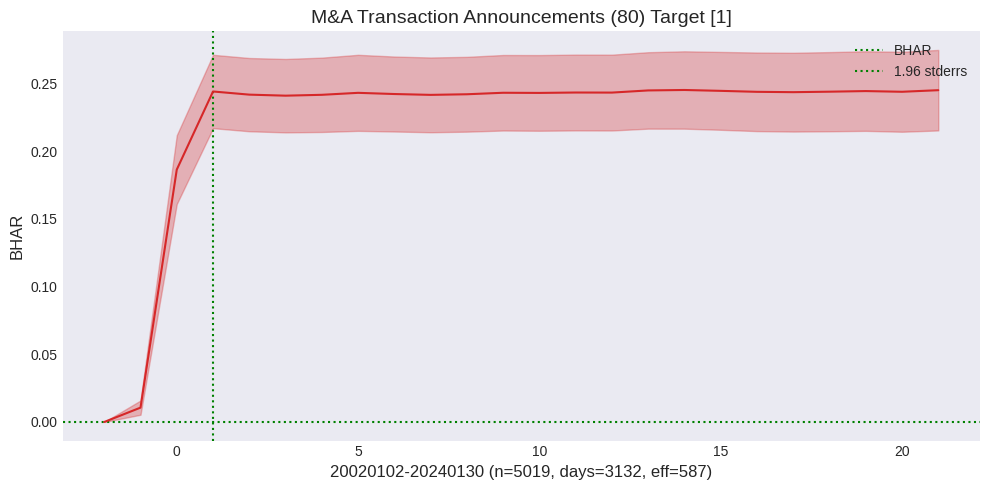

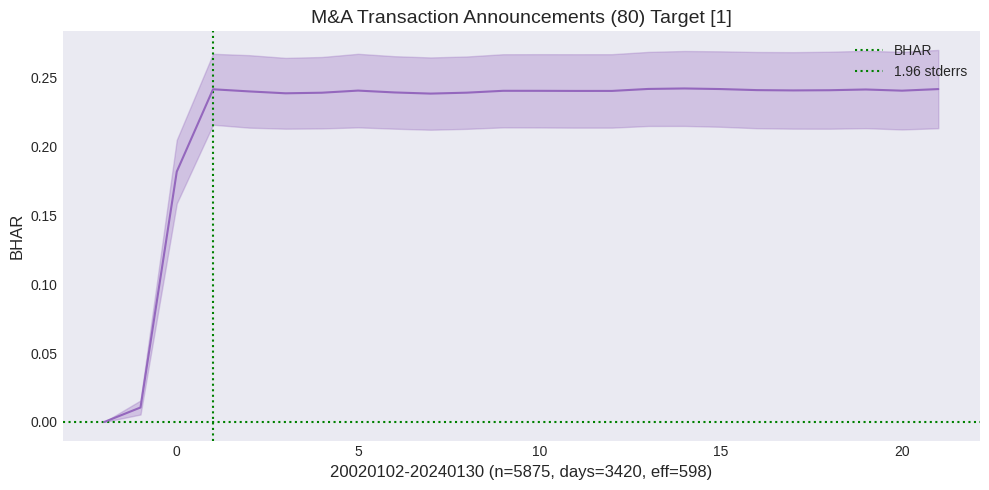

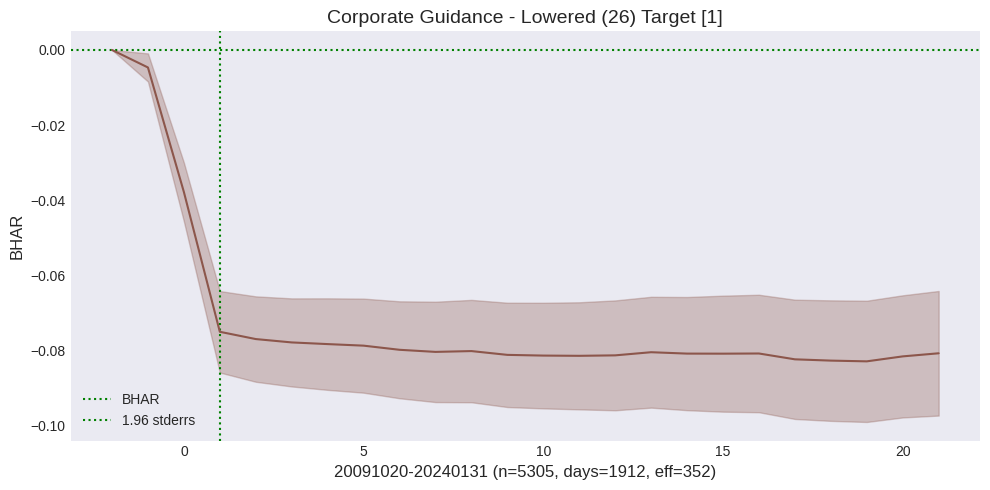

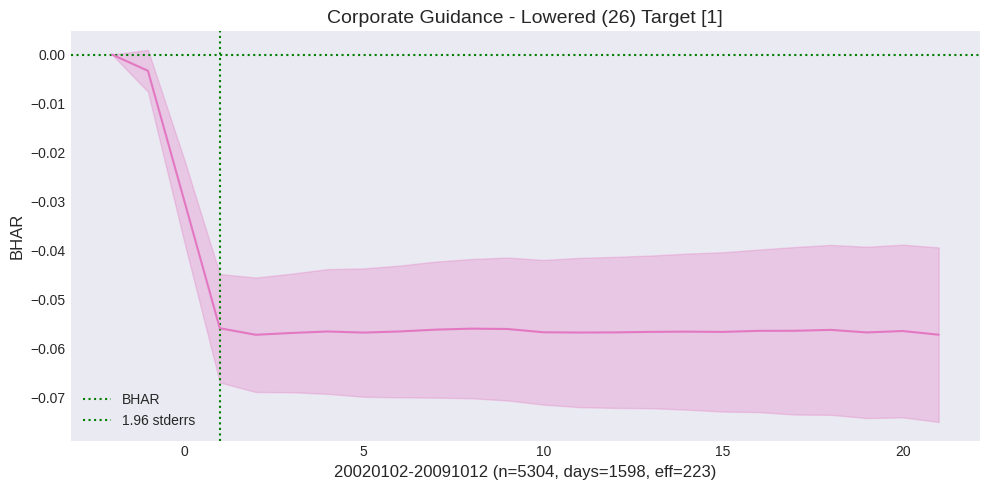

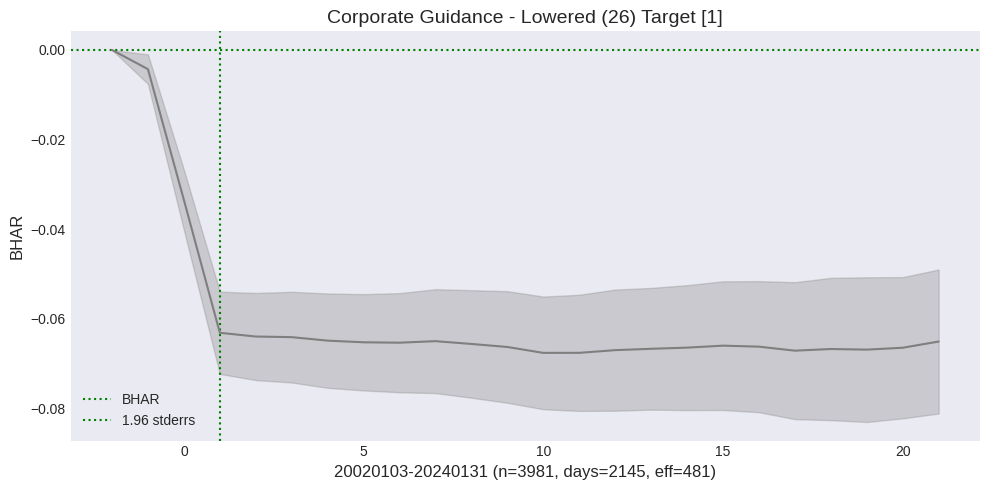

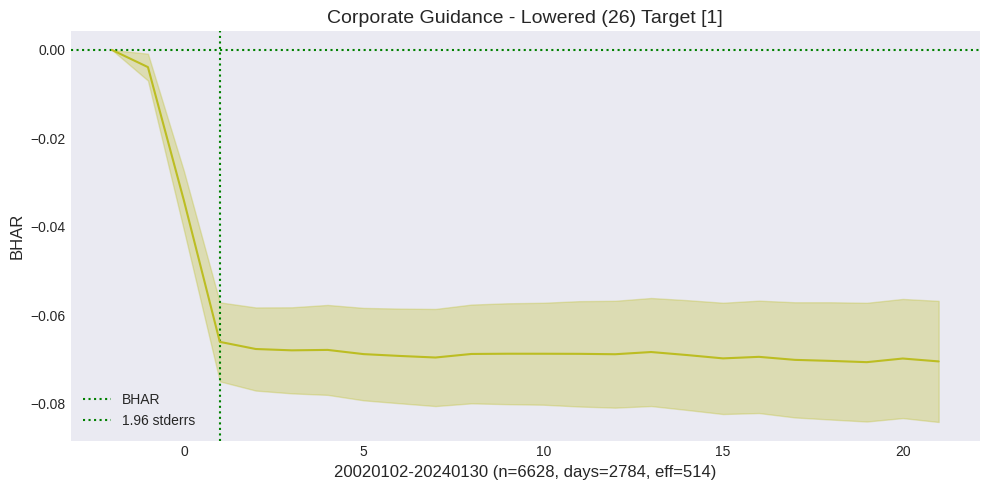

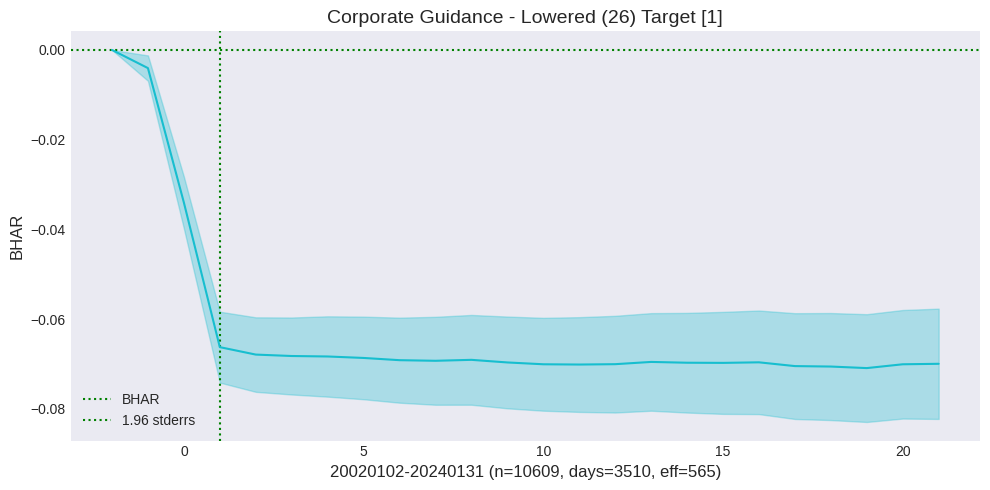

In [8]:
events_list = [[80,1], [26,1]]  # largest announcement window returns
for i, (eventid, roleid) in enumerate(events_list):
    #eventid, roleid = 50, 1
    #eventid, roleid = 83, 1
    df = event_pipeline(eventstudy,
                        eventid=eventid,
                        roleid=roleid,
                        beg=beg,
                        end=end,
                        left=left,
                        right=right,
                        post=post)
    halfperiod = np.median(df['announcedate'])
    sample = {'FirstHalf': df['announcedate'].ge(halfperiod).values,
              'SecondHalf': df['announcedate'].lt(halfperiod).values,
              'Large': df['size'].le(5).values,
              'Small': df['size'].gt(5).values,
              '': []}
    for ifig, (label, rows) in enumerate(sample.items()):
        fig, ax = plt.subplots(clear=True, figsize=(10, 5))
        bhar = eventstudy.fit(model='sbhar', rows=rows)
        eventstudy.plot(model='sbhar',
                        title=eventformat(eventid, roleid),
                        drift=False,
                        ax=ax,
                        c=f"C{i*5+ifig}")
        plt.tight_layout()
        plt.savefig(imgdir / (label + f"{eventid}_{roleid}.jpg"))

## Cross correlation

Kolari et al (2018) consider event windows that partially overlap in calendar time, and modify standard errors and test statistics to adjust for the average percentage of overlaps in event windows and account for cross-sectional correlation effects.

$$\sigma^{2} = \dfrac{s^2}{n} m (1 + \tau (n - 1) \rho)$$

where $m$ is the length of the event window, $\tau$ is the ratio of number of overlapping calendar days of the event windows to the length of the event windows, and $\rho = \dfrac{\nu}{s^2}$ is the ratio of the average covariance between abnormal returns to their average variance. If the calendar time of the event day is the same for all firms such that all event periods are completely overlapping, and the residual series are standardized by their respecive standard deviations, then $\rho$ is just the average cross-sectional correlation of the estimation window residuals.

To approximate $\rho$: we assume that cross-sectional correlations between any two series are primarily due to their misalignment, where the number of time periods shifted is unknown. We first find the best alignment of event window residual returns between each pair of series that maximizes their pair-wise correlation, and then compute the average of these best-aligned correlations over all pairs.


### Convolution theorem

From the field of signal processing, frequency domain techniques are well suited for computing the cross-correlations at all lags between each pair of time series, and terming every pair-specific best alignment with maximum correlation. Directly computing the correlations for every possible lag between two series may seem computationally expensive over all possible pairs. Such an operation between between two series, known as a convolution, can be computed as a product of the fourier transforms of the two series. The relevant definitions and theorems are summarized below:

A convolution is a mathematical operation on two functions
($f$ and $g$) that produces a third function ($f*g$) which expresses
how the shape of one is modified by the other. It is defined as the integral of the product of the two functions after one is reflected about the y-axis and shifted.

$$(f * g)(t) = \int_{-\infty}^{\infty} f(s)g(t - s) ds = \int_{-\infty}^{\infty} f(t - s)g(s) ds$$

The Convolution Theorem states that under suitable conditions the Fourier transform of a convolution of two signals is the pointwise product of their Fourier transforms. More generally, convolution in the time domain equals point-wise multiplication in the frequency domain. Hence a convolution of two sequences can be obtained as the inverse transform of the product of the individual transforms. Let $*$ denote the convolution of two series:

  $$\mathcal{F}\{f(t) * g(t)\} = \mathcal{F}\{f(t)\} \mathcal{F}\{g(t)\} $$


Cross-correlation measures the similarity of two series as a function of the
displacement of one relative to the other. This is also known as a sliding dot product or sliding inner-product. Let $\star$ denote the
cross-correlation of two series, and $\overline{f}$ denote the
complex conjugate:

$$(f \star g)(t) = \int_{-\infty}^{\infty} \overline{f(s)}g(s + t) ds \int_{-\infty}^{\infty} \overline{f(s - t)} g(s) ds$$

The Cross-correlation Theorem states that the cross-correlation integral is
equivalent to the convolution integral if one of the input signals
is conjugated and time-reversed. 

$$[f(t) \star g(t)](\tau) = [\overline{f(-t)} * g(t)](\tau)$$

where $\tau$ is called the displacement or lag. For highly-correlated $f$ and $g$ which have a maximum cross-correlation at a particular $\tau$, a feature in $f$ at $t$ also occurs later in $g$ at $t + \tau$, hence $g$ could be described to lag $f$ by $\tau$.



In [39]:
# best alignment and cross-correlation using convolution theorem method
from scipy.fft import rfft, irfft
def fft_align(X):
    """Find best alignment, max cross-correlation and indices of all pairs of columns"""

    def _normalize(X: np.ndarray) -> np.ndarray:
        """Helper to demean columns and divide by norm"""
        X = X - np.mean(X, axis=0)
        X = X / np.linalg.norm(X, axis=0)
        return X

    N, M = X.shape
    X = np.pad(_normalize(X), [(0, N), (0,0)])  # normalize and zero pad
    Y = rfft(np.flipud(X), axis=0)              # FFT of all series flipped
    X = rfft(X, axis=0)                         # FFT of all original series
    corr, disp, cols = [], [], []               # to accumulate results
    for col in range(M-1):  # at each iter: compute column col * all remaining columns
        conv = irfft(X[:, [col]] * Y[:, col+1:], axis=0)  # inverse of product of FFT
        corr.extend(np.max(conv, axis=0))
        shift = (N//2) + 1           # displacement location relative to center
        disp.extend(((np.argmax(conv, axis=0) + shift) % N) - shift + 1)
        cols.extend([(col, j) for j in range(col+1, M)])
    return corr, disp, cols


In [37]:
Z = np.random.uniform(size=(10000, 1))
fft_align(np.hstack((Z[:-1], Z[1:])))


([0.9998344824121533], [1], [(0, 1)])

In [38]:
#fft_align(np.hstack(np.hstack((Z[:-5], Z[5:])))[:,2:], Z[:-2]) 
fft_align(np.hstack((np.hstack((Z[:-5], Z[5:]))[:-2], Z[7:])))

([0.9996045585524033, 0.9993741961936712, 0.9997696328132938],
 [5, 7, 2],
 [(0, 1), (0, 2), (1, 2)])

## Multiple testing problem

When testing a huge number of null hypotheses, we are bound to get
some very testing small p-values by chance. If we make a decision
about whether to reject each null hypothesis without accounting for
the fact that we have performed a very large number of tests, then we
may end up rejecting a great number of true null hypotheses -- that is,
making a large number of Type I errors.

__Data snooping__ occurs when the analyst fits a great number of models to
a dataset. When explanatory variables are selected using the data,
t-ratios and F-ratios will be too large, thus overstating the
importance of variables in the model.


Multiple testing adjusts the hurdle for significance because some tests will appear significant by
chance. The downside of doing this is that some truly significant strategies might be overlooked because they
did not pass the more stringent hurdle. This is the classic tension between Type I errors and Type II errors. The Type I error is the false discovery (investing in an unprofitable trading strategy). The Type II error is missing a truly profitable trading strategy.
Data snooping occurs when the analyst fits a great number of models to
a dataset. When explanatory variables are selected using the data,
t-ratios and F-ratios will be too large, thus overstating the
importance of variables in the model.

The false discovery rate (FDR) is the ratio of false discoveries to number
of positive tests, which is the sum of false discoveries (i.e. false
positives) and true positives. To calculate the false discovery
rate, we must take a guess at the fraction of tests that we do in
which there is a real difference, and the probability that the test
will give the right result when there is a real effect (power).
The FDR views unacceptable in terms of a proportion. For example, if one false discovery were unacceptable for 100 tests, then 10 are unacceptable for 1,000 tests. 


Family-wise error rate (FWER) generalizes this notion to the
setting of $m$ null hypotheses, $H_1 , ... , H_m$ , and is defined
as the probability error rate of making at least one Type I error.
If we make the additional rather
strong assumptions that the m tests are independent and that all m null
hypotheses are true, then

  $$\mathrm{FWER}(\alpha) = 1 - \prod_{j=1}^{m} (1 - \alpha) = 1 - (1 - \alpha)^m$$

In the family-wise error rate, it is unacceptable to
make a single false discovery. This is a very severe rule.

Given the p-values, the `multipletests` function from the `statsmodels` module outputs adjusted p-values, which can be thought of as a new set of p-values that have been corrected for multiple testing. If the adjusted p-value for a given hypothesis is less than or equal to alpha, then that hypothesis can be rejected while maintaining a FWER of no more than alpha. In other words, for such methods, the adjusted p-values resulting from the multipletests function can simply be compared to the desired FWER in order to determine whether or not to reject each hypothesis. We can use the same function to control FDR as well. 

Compute BHAR and CAR of all events


  0%|          | 0/116 [00:00<?, ?it/s]

100%|██████████| 116/116 [26:18:33<00:00, 816.50s/it]   


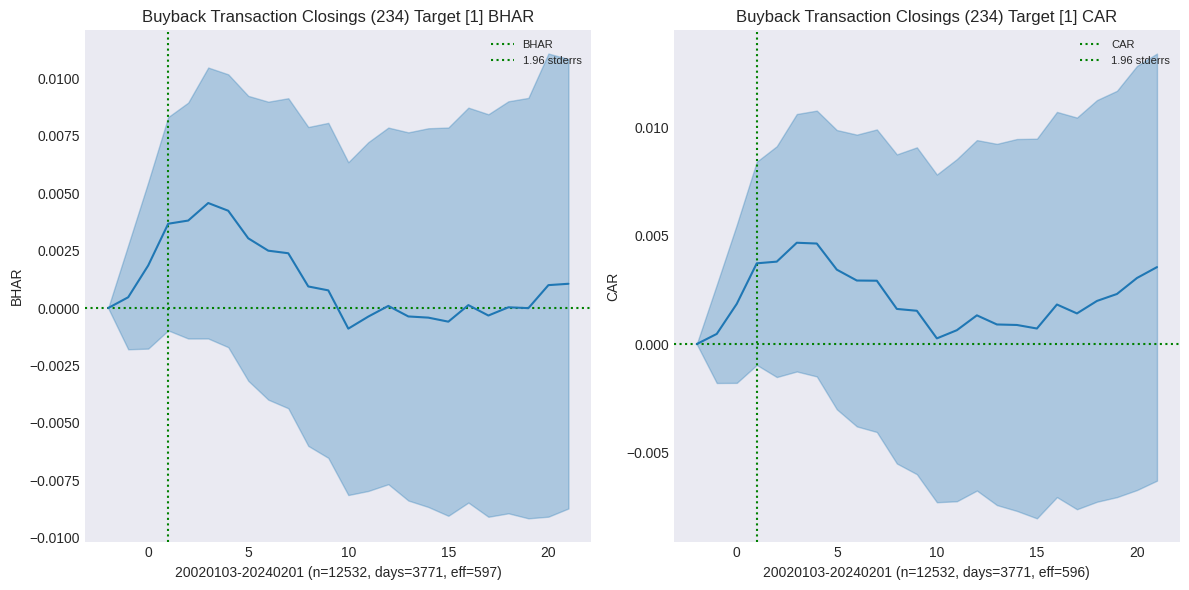

In [16]:
restart_event = 0 # 75,1
for i, eventid in tqdm(enumerate(events), total=len(events)):
    if eventid <= restart_event:  # kludge to resume loop
        continue
    for roleid in roles:
        # retrieve all returns observations of this eventid, roleid
        df = event_pipeline(eventstudy,
                            beg=beg,
                            end=end,
                            eventid=eventid,
                            roleid=roleid,
                            left=left,
                            right=right,
                            post=post)
        if df['announcedate'].nunique() < mindays:  # require min number of dates
            continue

        # compute both BHAR and CAR averages, then plot and save
        bhar = eventstudy.fit(model='sbhar')
        car = eventstudy.fit(model='scar')
        #eventstudy.write()
        eventstudy.write_summary()
        #print(eventstudy.label, eventid, roleid)

        fig, axes = plt.subplots(1, 2, clear=True, figsize=(12, 6), num=1)
        eventstudy.plot(model='sbhar', ax=axes[0],
                        title=eventformat(eventid, roleid) + ' BHAR',
                        fontsize=8, vline=[right])
        eventstudy.plot(model='scar', ax=axes[1],
                        title=eventformat(eventid, roleid) + ' CAR',
                        fontsize=8, vline=[right])
        plt.tight_layout()
        plt.savefig(imgdir / f"{eventid}_{roleid}.jpg")

Summarize BHAR's of all events


In [6]:
# Create (eventid, roleid) multiindex for table of all BHAR's
df = eventstudy.read_summary(model='sbhar')\
               .set_index('label')\
               .drop(columns=['rho', 'tau', 'created'])
df = df[df['effective'] > 400].sort_values('post_t')  # sorted by post drift t-stat
multiIndex = DataFrame(df.index.str.split('_').to_list()).astype(int)
df.index = pd.MultiIndex.from_frame(multiIndex, names=['eventid', 'roleid'])
df['event'] = keydev.event[df.index.get_level_values(0)].values
df['role'] = keydev.role[df.index.get_level_values(1)].values
print("Post-Announcement Drift")
pd.set_option('display.max_rows', None)
df.set_index(['event', 'role']).drop(columns=['model'])

Post-Announcement Drift


,,beg,end,rows,days,effective,window,window_t,post,post_t
event,role,,,,,,,,,
Shelf Registration Filings,Target,20020102,20240201,43968,5462,658.0,-0.005723,-2.953200,-0.010470,-2.287190
Changes in Company Bylaws/Rules,Target,20020430,20240201,26080,4614,567.0,0.000111,0.042656,-0.010652,-2.000120
Auditor Changes,Target,20020103,20240131,9232,3738,587.0,-0.003299,-1.106310,-0.011627,-1.737210
Name Changes,Target,20020430,20240130,1516,1282,434.0,0.012904,2.072100,-0.021342,-1.729880
Executive Changes - CFO,Target,20020102,20240201,21873,5337,652.0,-0.007732,-3.119900,-0.007747,-1.588070
Special/Extraordinary Shareholders Meeting,Target,20040106,20240131,5710,3176,513.0,-0.000755,-0.203839,-0.013482,-1.519900
Product-Related Announcements,Target,20020102,20240201,203597,5559,662.0,0.005881,4.758170,-0.003877,-1.467370
Investor Activism - Target Communication,Target,20020402,20240201,4995,2914,504.0,0.008170,1.945040,-0.007546,-1.198240
Executive/Board Changes - Other,Target,20020101,20240201,215926,5558,661.0,-0.000451,-0.442385,-0.002750,-1.189980


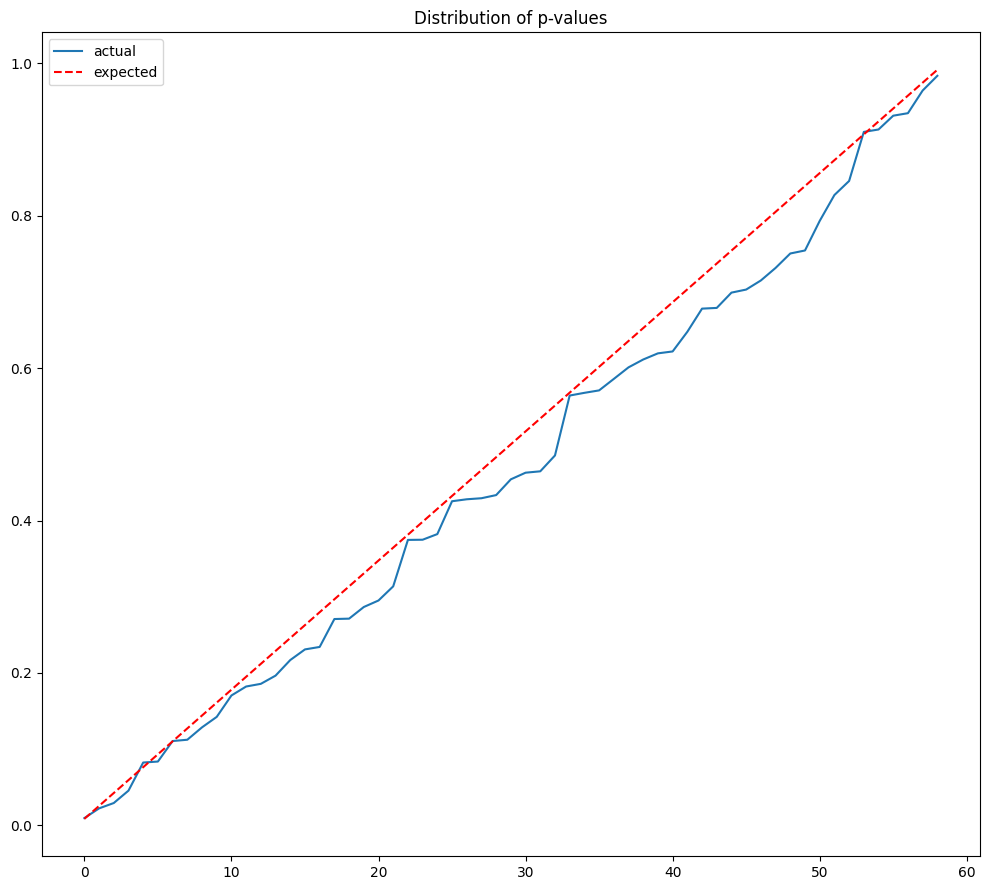

In [7]:
# Expected p-values (with continuity correction)
pvals = norm.cdf(-df['post_t'].abs()) * 2
fig, ax = plt.subplots(1, 1, clear=True, figsize=(10, 9))
ax.plot(sorted(pvals))
ax.plot([0, len(pvals)-1], [0.5/len(pvals), (len(pvals)-0.5)/len(pvals)], 'r--')
ax.set_title('Distribution of p-values')
ax.legend(['actual', 'expected'])
plt.tight_layout()

In [13]:
# Number of rejections with uncorrected pvals
#argmin = np.argmin(pvals)
#header = df.iloc[argmin][['event', 'role', 'days', 'effective', 'post_t']]
alpha = 0.05
uncorrected = DataFrame({'rejections': sum(pvals < alpha),
                         'min p-value': min(pvals)},
                        index=['uncorrected'])
uncorrected.round(4)

,rejections,min p-value
uncorrected,4,0.0094


### Bonferroni correction


The best-known FWER test is called the Bonferroni test which adjusts for the multiple tests. Given the chance that one test could randomly show up as significant, the Bonferroni requires the confidence level to increase. Instead of 5\%, you take the 5\% and divide by the number of tests, that is, 5\%/10 = 0.5\%. Again equivalently, you need to be 99.5\% confident with 10 tests that you are not making a single false discovery. In terms of the t-statistic, the Bonferroni requires a statistic of at least 2.8 for 10 tests. For 1,000 tests, the statistic must exceed 4.1.

It sets the threshold for rejecting each hypothesis to $\alpha/m$, by applying the union bound inequality:

  $$\mathrm{FWER}(\alpha) = \mathrm{Pr}(\cup_{j=1}^{m} A_j) \le                                  
  \sum_{j=1}^{m} \mathrm{Pr}(A_j) \le m \times \frac{\alpha}{m} = \alpha$$

where $A_j$ denotes the probability of rejecting the $j$-th
hypothesis. The Bonferroni correction can be quite conservative, in
the sense that the true FWER is often quite a bit lower than the
nominal (or target) FWER;




In [14]:
# The Bonferroni p-values bonf are simply the uncorrected pvalues multiplied by
# the number of samples and truncated to be less than or equal to 1.  
reject, bonf_corrected, _, _ =  multipletests(pvals, alpha=alpha, method='bonferroni')
bonf = DataFrame({'rejections': np.sum(bonf_corrected < alpha),
                  'min p-value': np.min(bonf_corrected)},
                 index=['bonferroni'])
pd.concat([uncorrected, bonf], axis=0).round(4)

,rejections,min p-value
uncorrected,4,0.0094
bonferroni,0,0.5562


### Holm's step-down procedure

Holm's method, also known as Holm's step-down procedure or the Holm-Bonferroni method, is an alternative to the Bonferroni procedure. Holm's method method controls the FWER, but it is less conservative than Bonferroni, in the sense that it will reject more null hypotheses, typically resulting in fewer Type II errors and hence greater power. Holm's method makes no independence assumptions about the hypothesis tests, and is uniformly more powerful than the Bonferroni method -- it will always reject at least as many null hypotheses as Bonferroni-- and so it should always be preferred. It is worth noting that in Holm's procedure, the threshold that we use to reject each null hypothesis actually depends on the values of all the p-values.

The Holm method begins by sorting the tests from the lowest p-value (most significant) to the highest (least significant), and comparing a threshold computed with the Holm function.  In contrast to the Bonferroni, which has a single threshold for all tests, the other tests will have a different hurdle under Holm. Starting from the first test, we sequentially compare the p-values with their hurdles. When we first come across the test such that its p-value fails to meet the hurdle, we reject this test and all others with higher p-values.



In [15]:
# Holm method
reject, holm_corrected, _, _ =  multipletests(pvals, alpha=alpha, method='holm')
holm = DataFrame({'rejections': np.sum(holm_corrected < alpha),
                  'min p-value': np.min(holm_corrected)},
                 index=['holm'])
pd.concat([uncorrected, bonf, holm], axis=0).round(4)

,rejections,min p-value
uncorrected,4,0.0094
bonferroni,0,0.5562
holm,0,0.5562


### Benjamin-Hochberg procedure

The false discovery rate approach allows an expected proportional error rate.  As such, it is less stringent than both the Bonferroni and the Holm test. FDR control is much milder -- and more powerful -- than FWER control, in the sense that it allows us to reject many more null hypotheses, with a cost of substantially more false positives.

Similar to the Holm test, Benjamin-Hochberg also relies on the distribution of test statistics. However, in contrast to the Holm test that begins with the most significant test, the Benjamin-Hochberg approach starts with the least significant.
We sort the tests from the lowest p-value (most significant) to the highest (least significant). Starting from the last test, we sequentially compare the p-values with their Benjamin-Hochberg thresholds. When we first come across the test such that its p-value falls below its threshold, we declare this test significant and all tests that have a lower p-value. 

The `multipletests` function can be used to carry out the Benjamini–Hochberg procedure.  The q-values output by the Benjamini–Hochberg procedure can be interpreted as the smallest FDR threshold at which we would reject a particular null hypothesis. For instance, a q-value of 0.1 indicates that we can reject the
corresponding null hypothesis at an FDR of 10% or greater, but that we cannot reject the null hypothesis at an FDR below 10%.

In [16]:
# Benjamini-Hochberg method
reject, fdr_bh_corrected, _, _ =  multipletests(pvals, alpha=alpha, method='fdr_bh')
fdr_bh = DataFrame({'rejections': np.sum(fdr_bh_corrected < alpha),
                    'min p-value': np.min(fdr_bh_corrected)},
                   index=['fdr_bh'])
pd.concat([uncorrected, bonf, holm, fdr_bh], axis=0).round(4)

,rejections,min p-value
uncorrected,4,0.0094
bonferroni,0,0.5562
holm,0,0.5562
fdr_bh,0,0.5562


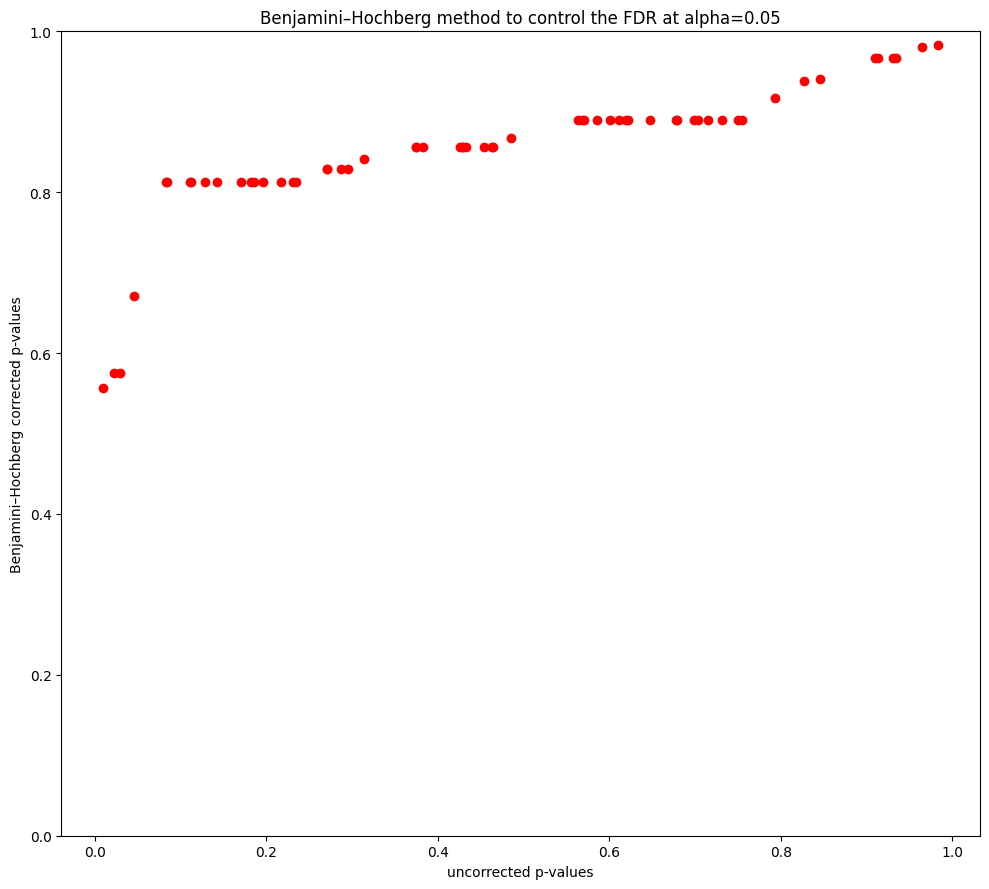

In [17]:
# Plot uncorrected and corrected p-values from Benjamini-Hochberg method
fig, ax = plt.subplots(figsize=(10, 9))
ax.scatter(pvals, fdr_bh_corrected, color='red')
ax.set_ylim(bottom=0, top=1)
ax.set_title(f"Benjamini–Hochberg method to control the FDR at alpha={alpha}")
ax.set_xlabel('uncorrected p-values')
ax.set_ylabel('Benjamini–Hochberg corrected p-values')
plt.tight_layout()